In [3]:
import os
import glob
import time
import numpy as np
import astropy.coordinates as coord
import numpy.ma as ma
import pandas as pd
from scipy.ndimage import convolve
from astropy.io import fits
import astropy.units as u
from astropy.io.fits import getval
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, SigmaClip, sigma_clip
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astroquery.vizier import Vizier
from photutils.background import Background2D, MedianBackground
import matplotlib.pyplot as plt
import argparse
import image_registration
import warnings

warnings.filterwarnings('ignore')

In [1]:
def load_fits(image, extension=0):
    with fits.open(image) as hdu:
        header = hdu[extension].header
        data = hdu[extension].data
    return data, header


def delete_extra_file(file):
    try:
        os.remove(file)
    except:
        print(file, 'file not found to delete')
        

def get_table_from_ldac(filename, frame=1):
    # To read cat file generated by sextractor
    if frame > 0:
        frame = frame*2
    tbl = Table.read(filename, hdu=frame)
    return tbl

def get_cam_parametres():
    ra_keyword = "TARRA"
    dec_keyword = "TARDEC"
    filt_keyword = "Filter"
    exp_time_keyword = 'EXPOSURE'
    jd_keyword = 'JD'
    objet_keyword = 'OBJECT'
    x_len = 4108
    y_len = 4096
    pix_scale = 0.676
    gain = 1.6  # in e-/ADU
    saturLevel = 51000  # in adu
    photoDistThresh = 1.2  # to cross match vizier and sex catalogue
    boxsize = 20  # for vizier query
    maxmag = 18  # for vizier query
    readNoise = 12.0  # in electrons
    return ra_keyword, dec_keyword, filt_keyword, exp_time_keyword, jd_keyword, objet_keyword, x_len, y_len, pix_scale, gain, saturLevel, photoDistThresh, boxsize, maxmag, readNoise

def get_params_of_image(image):
    ra_keyword, dec_keyword, filt_keyword, exp_time_keyword, jd_keyword, objet_keyword, _, _, _, _, _, _, _, _, _, = get_cam_parametres()
    data, header = load_fits(image)
    tar_ra = header[ra_keyword]
    tar_dec = header[dec_keyword]
    filt = header[filt_keyword]
    exp_time = header[exp_time_keyword]
    jd = header[jd_keyword]
    object_name = header[objet_keyword]
    return tar_ra, tar_dec, filt, exp_time, jd, object_name

def get_configfile_names(config_path):
    sex_config = config_path + 'astrom.sex'
    sex_param = config_path + 'astrom.param'
    psfex_config = config_path + 'photometry.psfex'
    sex_psf_param = config_path + 'sex_PSF.param'

    # sex_config = config_path + 'photomCat.sex'
    # sex_param = config_path + 'photomCat.param'
    # psfex_config = config_path + 'psfex_conf.psfex'
    # sex_psf_param = config_path + 'photomPSF.param'
    return sex_config, sex_param, psfex_config, sex_psf_param

def run_sextractor(image, gain, saturLevel, sex_config, sex_param):
    # Running sex to get cat file for masking (and to get_psf)
    sex_cmd = f"sex -c {sex_config} {image} -CATALOG_NAME {image}.cat -GAIN {gain} -SATUR_LEVEL {saturLevel} -WEIGHT_TYPE NONE -PARAMETERS_NAME {sex_param}"
    # print(sex_cmd)
    try:
        os.system(sex_cmd)
    except:
        print(f"Could not run sex on {image}")
    # output catfile is image+'.cat'
    return

def get_psf(image, psfex_config):
    catfile = image+'.cat'
    # running PSFex to get psf
    psfex_cmd = f"psfex -c {psfex_config} {catfile}"
    print(psfex_cmd)
    try:
        os.system(psfex_cmd)
    except:
        print(f"Could not run PSFex on {image}")
    # saving psf model
    image_psf = image + '.psf'
    psf_data = fits.open(image_psf)[1].data[0][0][0]
    psf_data = psf_data / np.sum(psf_data)
    psf_model_hdu = fits.PrimaryHDU(psf_data)
    psf_model_hdu.writeto(image + '.psfmodel', overwrite=True)
    # removing extra files
    delete_extra_file(catfile)
    return psf_data

def run_sextractor_with_PSF(image, gain, saturLevel, sex_config, sex_psf_param):
    # Running PSF Sextractor to get psf_cat file
    image_psf = image + '.psf'
    image_chi = 'chi'+image+'.fits'
    sex_psf_cmd = f"sex -c {sex_config} {image} -CATALOG_NAME {image}.psf.cat -GAIN {gain} -SATUR_LEVEL {saturLevel} -WEIGHT_TYPE NONE -PSF_NAME {image_psf} -PARAMETERS_NAME {sex_psf_param}"
    try:
        os.system(sex_psf_cmd)
    except:
        print(f"Could not run psf sex on {image}")
    # removing extra files
    delete_extra_file(image_psf)
    delete_extra_file(image_chi)
    return

def psf_fit(backsub_cutout, psf_data):
    backsub_cutout = backsub_cutout[15: 45, 15: 45]
    psf_data = psf_data[15: 45, 15: 45]
    xoff, yoff, exoff, eyoff = image_registration.chi2_shifts.chi2_shift(
        psf_data, backsub_cutout, 10, boundary='wrap', nfitted=2, upsample_factor='auto')
    print(
        f"peak of source detected at offset {xoff, yoff} (in pixel) from target position")
    if abs(xoff) > 5.0 or abs(yoff) > 5.0:
        # xoff = 0.0
        # yoff = 0.0
        phot_type = 'Forced_PSF'
    else:
        phot_type = 'PSF'
    resize_backsub_cutout = image_registration.fft_tools.shift2d(
        backsub_cutout, -xoff, -yoff)
    flux = np.sum(resize_backsub_cutout*psf_data)/np.sum(psf_data*psf_data)
    #convolved = convolve(resize_backsub_cutout, psf_data, mode='constant')
    #flux = np.sum(convolved)
    return flux, phot_type

def cal_inst_mag(psf_data, image, x_list, y_list):
    saturLevel = 51000
    image_data, image_header = load_fits(image)
    jd = getval(image, 'JD')
    filt = getval(image, 'FILTER')
    print(os.path.basename(image), filt, jd)
    flux = []
    sigma_flux = []
    int_mag = []
    int_mag_err = []
    PSF_type = []
    is_saturated = []
    for i in range(len(x_list)):
        x = int(x_list[i])
        y = int(y_list[i])
        cutout = Cutout2D(image_data, position=(
            x, y), size=np.shape(psf_data))
        Is = cutout.data
        is_saturated_ = np.ravel(Is > saturLevel).any()
        sigma_clip = SigmaClip(sigma=3.0)
        try:
            bkg_estimator = MedianBackground()
            bkg = Background2D(Is, np.shape(psf_data), filter_size=(
                3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
            background = bkg.background
        except:
            _, background, _ = sigma_clipped_stats(Is)
        sigma_flux_ = np.sqrt(np.sum(Is*psf_data**2)) / np.sum(psf_data*psf_data)
        Is = Is-background
        flux_, PSF_type_ = psf_fit(Is, psf_data)
        int_mag_ = -2.5*np.log10(flux_)
        int_mag_err_ = 2.5*np.log10(1 + sigma_flux_/flux_)
        flux.append(flux_)
        sigma_flux.append(sigma_flux_)
        int_mag.append(int_mag_)
        int_mag_err.append(int_mag_err_)
        PSF_type.append(PSF_type_)
        is_saturated.append(is_saturated_)
    return flux, sigma_flux, int_mag, int_mag_err, PSF_type, is_saturated

def get_results(image, x_list, y_list):
    jd = getval(image, 'JD')
    filt = getval(image, 'FILTER')
    psf_data = fits.open(image+'.psfmodel')[0].data
    #psf_data = fits.open(os.path.dirname(image) + '/moffat_' +os.path.basename(image)+'.fits')[0].data
    flux, sigma_flux, int_mag, int_mag_err, PSF_type, is_saturated = cal_inst_mag(
        psf_data, image, x_list, y_list)
    data = pd.DataFrame()
    add_data = pd.DataFrame(
        columns=['Image', 'Filter', 'JD', 'tar_flux', 'tar_flux_err', 'tar_int_mag', 'tar_int_mag_err', 'tar_PSF_type', 'tar_is_saturated'])
    for i in range(len(flux)):
        if i == 0:
            add_data.loc[0, 'tar_flux'] = flux[0]
            add_data.loc[0, 'tar_flux_err'] = sigma_flux[0]
            add_data.loc[0, 'tar_int_mag'] = int_mag[0]
            add_data.loc[0, 'tar_int_mag_err'] = int_mag_err[0]
            add_data.loc[0, 'tar_PSF_type'] = PSF_type[0]
            add_data.loc[0, 'tar_is_saturated'] = is_saturated[0]
        else:
            add_data[f'flux_{i-1}'] = flux[i]
            add_data[f'flux_err_{i-1}'] = sigma_flux[i]
            add_data[f'int_mag_{i-1}'] = int_mag[i]
            add_data[f'int_mag_err_{i-1}'] = int_mag_err[i]
            add_data[f'PSF_type_{i-1}'] = PSF_type[i]
            add_data[f'is_saturated_{i-1}'] = is_saturated[i]
    add_data['Image'] = os.path.basename(image)
    add_data['Filter'] = filt
    add_data['JD'] = jd
    data = pd.concat([data, add_data])
    csv_file = f'/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/csv/final_u_results.csv'
    data.to_csv(csv_file, mode='a', index=False,
                header=not os.path.exists(csv_file))
    print('flux:', flux)
    print('sigma_flux:', sigma_flux)
    print('int_mag:', int_mag)
    print('int_mag_err:', int_mag_err)
    print('PSF_type:', PSF_type)
    print('is_saturated:', is_saturated)
    return


## After saving the generated psf, no need to run it again

In [4]:
# Path to the directory containing the .wcs.proc.fits files
base_path = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band'
config_path = '/home/gauravbhoir147/Documents/Files/Kritika/Conf/'

# Get all .wcs.proc.fits files in the base_path directory
images = glob.glob(os.path.join(base_path, '*.wcs.proc.fits'))

def process_images(images):
    for image in images:
        ra_keyword, dec_keyword, filt_keyword, exp_time_keyword, jd_keyword, objet_keyword, x_len, y_len, pix_scale, gain, saturLevel, photoDistThresh, boxsize, maxmag, readNoise = get_cam_parametres()
        tar_ra, tar_dec, filt, exp_time, jd, object_name = get_params_of_image(image)
        sex_config, sex_param, psfex_config, sex_psf_param = get_configfile_names(config_path)
        run_sextractor(image, gain, saturLevel, sex_config, sex_param)
        psf_data = get_psf(image, psfex_config)
        run_sextractor_with_PSF(image, gain, saturLevel, sex_config, sex_psf_param)

# Change directory to the base_path directory
if images:
    os.chdir(base_path)
    process_images(images)
else:
    print("No .wcs.proc.fits files found in the directory.")


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:40:57 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521151021-504-RA.wcs.proc.fits
----- Measuring from: 20230521151021-504-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 501.625    RMS: 35.0343    / Threshold: 350.343    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521151021-504-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:41:00 with 4 threads

> 
----- 1 input catalogues:
20230521151021-504-R:  "SN2023ixf       "    1 extension      14 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230521151021-504-RA.wcs.proc.fits...
> Computing final PSF model for 20230521151021-504-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230521151021-504-RA.wcs.proc.fits...
20230521151021-50            5/5       0.55   0.63   2.93  0.05  0.05  0.08
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521151021-504-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -83.3703   RMS: 12.5718    / Threshold: 125.718    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        2 detected /        0 sextracted
> Line:  125  Objects:        2 detected /        0 sextracted
> Line:  150  Objects:        3 detected /        0 sextracted
> Line:  175  Objects:        3 detected /        0 sextracted
> Line:  200  Objects:        4 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522153940-706-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230522153940-706-RA.wcs.proc.fits...
20230522153940-70           11/11      0.61   0.59   3.61  0.05  0.08  0.12
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230522153940-706-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:41:10 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522153940-706-RA.wcs.proc.fits
----- Measuring from: 20230522153940-706-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522153940-706-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -44.7442   RMS: 9.98393    / Threshold: 99.8393    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        2 detected /        0 sextracted
> Line:  125  Objects:        3 detected /        0 sextracted
> Line:  150  Objects:        4 detected /        0 sextracted
> Line:  175  Objects:        5 detected /        0 sextracted
> Line:  200  Objects:        5 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230523210158-212-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230523210158-212-RA.wcs.proc.fits...
20230523210158-21           10/10      0.60   1.70   3.42  0.03  0.08  0.12
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230523210158-212-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 5.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:41:18 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230523210158-212-RA.wcs.proc.fits
----- Measuring from: 20230523210158-212-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230523210158-212-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -32.2217   RMS: 12.167     / Threshold: 121.67     
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Objects:        2 detected /        0 sextracted
> Line:  125  Objects:        2 detected /        0 sextracted
> Line:  150  Objects:        3 detected /        0 sextracted
> Line:  175  Objects:        3 detected /        0 sextracted
> Line:  200  Objects:        3 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525185233-041-RA.wcs.proc.fits.cat


20230525185233-04            9/9       0.67   0.70   4.11  0.01  0.05  0.08
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230525185233-041-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:41:26 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525185233-041-RA.wcs.proc.fits
----- Measuring from: 20230525185233-041-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525185233-041-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:41:27 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525191115-290-RA.wcs.proc.fits
----- Measuring from: 20230525191115-290-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -32.7728   RMS: 12.1558    / Threshold: 121.558    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525191115-290-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:41:30 with 4 threads

> 
----- 1 input catalogues:
20230525191115-290-R:  "SN2023ixf       "    1 extension      34 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230525191115-290-RA.wcs.proc.fits...
> Computing final PSF model for 20230525191115-290-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230525191115-290-RA.wcs.proc.fits...
20230525191115-29            8/8       0.64   0.79   4.07  0.02  0.04  0.06
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525191115-290-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -73.9527   RMS: 12.9364    / Threshold: 129.364    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526153145-192-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230526153145-192-RA.wcs.proc.fits...
20230526153145-19           12/12      0.60   0.98   3.47  0.01  0.08  0.12
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230526153145-192-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:41:38 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526153145-192-RA.wcs.proc.fits
----- Measuring from: 20230526153145-192-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526153145-192-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -71.627    RMS: 12.8787    / Threshold: 128.787    
> Scanning image
> Line:   25  Objects:        2 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Objects:        2 detected /        0 sextracted
> Line:  125  Objects:        2 detected /        0 sextracted
> Line:  150  Objects:        3 detected /        0 sextracted
> Line:  175  Objects:        3 detected /        0 sextracted
> Line:  200  Objects:        4 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526154548-720-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:41:42 with 4 threads

> 
----- 1 input catalogues:
20230526154548-720-R:  "SN2023ixf       "    1 extension      40 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230526154548-720-RA.wcs.proc.fits...
> Computing final PSF model for 20230526154548-720-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230526154548-720-RA.wcs.proc.fits...
20230526154548-72            9/9       0.56   2.81   3.09  0.13  0.52  0.82
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526154548-720-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:41:47 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526154827-798-RA.wcs.proc.fits
----- Measuring from: 20230526154827-798-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -73.7228   RMS: 12.9236    / Threshold: 129.236    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526154827-798-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230526154827-798-RA.wcs.proc.fits...
20230526154827-79            7/7       0.56   0.75   3.83  0.04  0.10  0.13
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230526154827-798-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 5.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:42:02 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526154827-798-RA.wcs.proc.fits
----- Measuring from: 20230526154827-798-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526154827-798-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:42:03 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230530175709-516-RA.wcs.proc.fits
----- Measuring from: 20230530175709-516-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -45.6886   RMS: 12.8593    / Threshold: 128.593    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530175709-516-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:42:14 with 4 threads

> 
----- 1 input catalogues:
20230530175709-516-R:  "SN2023ixf       "    1 extension      37 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230530175709-516-RA.wcs.proc.fits...
> Computing final PSF model for 20230530175709-516-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230530175709-516-RA.wcs.proc.fits...
20230530175709-51            5/5       0.67   0.35   3.99  0.04  0.07  0.10
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530175709-516-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:42:18 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603151832-158-RA.wcs.proc.fits
----- Measuring from: 20230603151832-158-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -29.5982   RMS: 13.0979    / Threshold: 130.979    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603151832-158-RA.wcs.proc.fits.cat


20230603151832-15           11/11      0.68   0.89   3.34  0.06  0.17  0.24
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230603151832-158-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:42:35 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603151832-158-RA.wcs.proc.fits
----- Measuring from: 20230603151832-158-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603151832-158-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:42:35 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604151735-580-RA.wcs.proc.fits
----- Measuring from: 20230604151735-580-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -36.991    RMS: 12.6265    / Threshold: 126.265    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604151735-580-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:43:05 with 4 threads

> 
----- 1 input catalogues:
20230604151735-580-R:  "SN2023ixf       "    1 extension      38 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230604151735-580-RA.wcs.proc.fits...
> Computing final PSF model for 20230604151735-580-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230604151735-580-RA.wcs.proc.fits...
20230604151735-58           10/10      0.63   0.64   3.33  0.04  0.09  0.15
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604151735-580-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:43:16 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604152014-648-RA.wcs.proc.fits
----- Measuring from: 20230604152014-648-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -40.9111   RMS: 12.6253    / Threshold: 126.253    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604152014-648-RA.wcs.proc.fits.cat


20230604152014-64            8/8       0.65   0.66   3.25  0.05  0.11  0.18
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230604152014-648-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:43:35 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604152014-648-RA.wcs.proc.fits
----- Measuring from: 20230604152014-648-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604152014-648-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:43:36 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605153355-567-RA.wcs.proc.fits
----- Measuring from: 20230605153355-567-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -12.9805   RMS: 12.4252    / Threshold: 124.252    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605153355-567-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:43:42 with 4 threads

> 
----- 1 input catalogues:
20230605153355-567-R:  "SN2023ixf       "    1 extension      40 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230605153355-567-RA.wcs.proc.fits...
> Computing final PSF model for 20230605153355-567-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230605153355-567-RA.wcs.proc.fits...
20230605153355-56            7/7       0.67   0.43   3.74  0.04  0.10  0.15
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605153355-567-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 3.84512    RMS: 12.3146    / Threshold: 123.146    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605161605-293-RA.wcs.proc.fits.cat


20230605161605-29            3/3       0.84   0.36   4.54  0.05  0.05  0.08
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230605161605-293-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:43:52 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605161605-293-RA.wcs.proc.fits
----- Measuring from: 20230605161605-293-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605161605-293-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:43:53 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230606150133-789-RA.wcs.proc.fits
----- Measuring from: 20230606150133-789-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -32.8544   RMS: 12.657     / Threshold: 126.57     
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230606150133-789-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:43:55 with 4 threads

> 
----- 1 input catalogues:
20230606150133-789-R:  "SN2023ixf       "    1 extension      39 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230606150133-789-RA.wcs.proc.fits...
> Computing final PSF model for 20230606150133-789-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230606150133-789-RA.wcs.proc.fits...
20230606150133-78            9/9       0.64   0.65   4.06  0.03  0.11  0.16
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230606150133-789-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:00 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230606151509-544-RA.wcs.proc.fits
----- Measuring from: 20230606151509-544-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 8.90012    RMS: 13.5767    / Threshold: 135.767    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230606151509-544-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:44:08 with 4 threads

> 
----- 1 input catalogues:
20230606151509-544-R:  "SN2023ixf       "    1 extension     287 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230606151509-544-RA.wcs.proc.fits...
> Computing final PSF model for 20230606151509-544-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230606151509-544-RA.wcs.proc.fits...
20230606151509-54           83/107     0.77   1.78   3.80  0.01  0.07  0.13
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230606151509-544-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:11 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521150712-428-RA.wcs.proc.fits
----- Measuring from: 20230521150712-428-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 517.191    RMS: 35.2319    / Threshold: 352.319    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521150712-428-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230521150712-428-RA.wcs.proc.fits...
20230521150712-42            3/3       0.57   0.93   2.93  0.05  0.06  0.11
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230521150712-428-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:16 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521150712-428-RA.wcs.proc.fits
----- Measuring from: 20230521150712-428-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521150712-428-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -84.3269   RMS: 12.5627    / Threshold: 125.627    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522152710-757-RA.wcs.proc.fits.cat


20230522152710-75           10/10      0.65   0.72   3.39  0.07  0.06  0.09
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230522152710-757-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:21 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522152710-757-RA.wcs.proc.fits
----- Measuring from: 20230522152710-757-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522152710-757-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:22 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524181219-697-RA.wcs.proc.fits
----- Measuring from: 20230524181219-697-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -9.34159   RMS: 9.53547    / Threshold: 95.3547    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524181219-697-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230524181219-697-RA.wcs.proc.fits...
20230524181219-69            3/3       0.43   0.58   1.47  0.20  0.20  0.56
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230524181219-697-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 4.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:28 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524181219-697-RA.wcs.proc.fits
----- Measuring from: 20230524181219-697-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524181219-697-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -11.9792   RMS: 9.56655    / Threshold: 95.6655    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        5 detected /        0 sextracted
> Line:  200  Objects:        5 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524181528-778-RA.wcs.proc.fits.cat


20230524181528-77            4/4       0.68   0.68   4.39  0.05  0.18  0.27
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230524181528-778-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:34 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524181528-778-RA.wcs.proc.fits
----- Measuring from: 20230524181528-778-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524181528-778-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:34 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524182956-255-RA.wcs.proc.fits
----- Measuring from: 20230524182956-255-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -9.63905   RMS: 9.53549    / Threshold: 95.3549    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524182956-255-RA.wcs.proc.fits.cat


20230524182956-25            3/3       0.98   0.74   4.57  0.11  0.05  0.07
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230524182956-255-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:39 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524182956-255-RA.wcs.proc.fits
----- Measuring from: 20230524182956-255-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524182956-255-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:40 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525184923-965-RA.wcs.proc.fits
----- Measuring from: 20230525184923-965-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -29.7052   RMS: 12.1675    / Threshold: 121.675    
> Scanning image
> Line:   25  Objects:        2 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525184923-965-RA.wcs.proc.fits.cat


20230525184923-96           10/10      0.66   0.79   3.75  0.04  0.06  0.09
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230525184923-965-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 1.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:43 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525184923-965-RA.wcs.proc.fits
----- Measuring from: 20230525184923-965-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525184923-965-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -74.9636   RMS: 12.9572    / Threshold: 129.572    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526153424-267-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230526153424-267-RA.wcs.proc.fits...
20230526153424-26           12/12      0.60   0.97   3.46  0.01  0.07  0.11
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230526153424-267-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:52 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230526153424-267-RA.wcs.proc.fits
----- Measuring from: 20230526153424-267-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526153424-267-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -38.6559   RMS: 12.5168    / Threshold: 125.168    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        4 detected /        0 sextracted
> Line:  125  Objects:        4 detected /        0 sextracted
> Line:  150  Objects:        6 detected /        0 sextracted
> Line:  175  Objects:        6 detected /        0 sextracted
> Line:  200  Objects:        6 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145847-598-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230527145847-598-RA.wcs.proc.fits...
20230527145847-59            8/8       0.59   0.54   3.55  0.06  0.10  0.15
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230527145847-598-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:44:57 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527145847-598-RA.wcs.proc.fits
----- Measuring from: 20230527145847-598-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145847-598-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -44.1729   RMS: 12.4341    / Threshold: 124.341    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527151004-669-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:45:00 with 4 threads

> 
----- 1 input catalogues:
20230527151004-669-R:  "SN2023ixf       "    1 extension      34 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230527151004-669-RA.wcs.proc.fits...
> Computing final PSF model for 20230527151004-669-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230527151004-669-RA.wcs.proc.fits...
20230527151004-66            8/8       0.62   0.55   4.14  0.01  0.11  0.15
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527151004-669-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -47.5661   RMS: 12.3951    / Threshold: 123.951    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527151243-755-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230527151243-755-RA.wcs.proc.fits...
20230527151243-75           10/10      0.60   1.09   2.17  0.11  0.20  0.29
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230527151243-755-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:09 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527151243-755-RA.wcs.proc.fits
----- Measuring from: 20230527151243-755-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527151243-755-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -47.1558   RMS: 12.8676    / Threshold: 128.676    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530175948-598-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:45:12 with 4 threads

> 
----- 1 input catalogues:
20230530175948-598-R:  "SN2023ixf       "    1 extension      34 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230530175948-598-RA.wcs.proc.fits...
> Computing final PSF model for 20230530175948-598-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230530175948-598-RA.wcs.proc.fits...
20230530175948-59            5/5       0.57   0.53   3.59  0.02  0.08  0.10
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530175948-598-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:15 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604153151-631-RA.wcs.proc.fits
----- Measuring from: 20230604153151-631-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -40.2312   RMS: 12.6884    / Threshold: 126.884    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604153151-631-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230604153151-631-RA.wcs.proc.fits...
20230604153151-63           10/10      0.58   0.57   3.43  0.04  0.06  0.09
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230604153151-631-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 4.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:21 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604153151-631-RA.wcs.proc.fits
----- Measuring from: 20230604153151-631-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604153151-631-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -42.5777   RMS: 12.7191    / Threshold: 127.191    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        2 detected /        0 sextracted
> Line:  125  Objects:        2 detected /        0 sextracted
> Line:  150  Objects:        3 detected /        0 sextracted
> Line:  175  Objects:        3 detected /        0 sextracted
> Line:  200  Objects:        3 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604153430-706-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230604153430-706-RA.wcs.proc.fits...
20230604153430-70           10/10      0.57   0.52   3.01  0.09  0.08  0.12
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230604153430-706-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:28 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230604153430-706-RA.wcs.proc.fits
----- Measuring from: 20230604153430-706-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604153430-706-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:29 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605145329-795-RA.wcs.proc.fits
----- Measuring from: 20230605145329-795-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -17.2144   RMS: 12.3348    / Threshold: 123.348    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605145329-795-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230605145329-795-RA.wcs.proc.fits...
20230605145329-79            7/7       0.63   0.37   4.13  0.10  0.11  0.15
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230605145329-795-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:37 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605145329-795-RA.wcs.proc.fits
----- Measuring from: 20230605145329-795-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605145329-795-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:37 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605153116-506-RA.wcs.proc.fits
----- Measuring from: 20230605153116-506-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -9.36481   RMS: 12.327     / Threshold: 123.27     
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605153116-506-RA.wcs.proc.fits.cat


20230605153116-50            7/7       0.70   0.50   3.88  0.05  0.11  0.14
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230605153116-506-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:42 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605153116-506-RA.wcs.proc.fits
----- Measuring from: 20230605153116-506-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605153116-506-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -8.70573   RMS: 12.6636    / Threshold: 126.636    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605171523-499-RA.wcs.proc.fits.cat


20230605171523-49            5/5       0.68   0.60   4.42  0.03  0.11  0.17
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230605171523-499-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:47 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605171523-499-RA.wcs.proc.fits
----- Measuring from: 20230605171523-499-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605171523-499-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:45:48 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230520151245-818-RA.wcs.proc.fits
----- Measuring from: 20230520151245-818-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -49.352    RMS: 12.6127    / Threshold: 126.127    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230520151245-818-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230520151245-818-RA.wcs.proc.fits...
20230520151245-81            8/8       0.63   0.59   2.94  0.10  0.08  0.14
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230520151245-818-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:05 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230520151245-818-RA.wcs.proc.fits
----- Measuring from: 20230520151245-818-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230520151245-818-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:07 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230520151524-890-RA.wcs.proc.fits
----- Measuring from: 20230520151524-890-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -55.4189   RMS: 12.6424    / Threshold: 126.424    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230520151524-890-RA.wcs.proc.fits.cat


20230520151524-89           11/11      0.64   0.79   3.23  0.10  0.08  0.14
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230520151524-890-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 1.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:11 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230520151524-890-RA.wcs.proc.fits
----- Measuring from: 20230520151524-890-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230520151524-890-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:12 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521154549-744-RA.wcs.proc.fits
----- Measuring from: 20230521154549-744-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -34.8073   RMS: 12.5798    / Threshold: 125.798    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521154549-744-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230521154549-744-RA.wcs.proc.fits...
20230521154549-74           11/11      0.62   0.61   3.10  0.06  0.08  0.13
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230521154549-744-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:17 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230521154549-744-RA.wcs.proc.fits
----- Measuring from: 20230521154549-744-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521154549-744-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -82.6938   RMS: 12.5596    / Threshold: 125.596    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Objects:        2 detected /        0 sextracted
> Line:  125  Objects:        2 detected /        0 sextracted
> Line:  150  Objects:        3 detected /        0 sextracted
> Line:  175  Objects:        3 detected /        0 sextracted
> Line:  200  Objects:        3 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522152401-684-RA.wcs.proc.fits.cat


20230522152401-68            9/9       0.67   0.73   3.25  0.04  0.04  0.06
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230522152401-684-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 1.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:21 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522152401-684-RA.wcs.proc.fits
----- Measuring from: 20230522152401-684-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522152401-684-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:22 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230522154249-788-RA.wcs.proc.fits
----- Measuring from: 20230522154249-788-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -84.7026   RMS: 12.6159    / Threshold: 126.159    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522154249-788-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:46:24 with 4 threads

> 
----- 1 input catalogues:
20230522154249-788-R:  "SN2023ixf       "    1 extension      51 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230522154249-788-RA.wcs.proc.fits...
> Computing final PSF model for 20230522154249-788-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230522154249-788-RA.wcs.proc.fits...
20230522154249-78           12/12      0.64   0.67   3.31  0.07  0.06  0.10
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522154249-788-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:27 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230523210507-283-RA.wcs.proc.fits
----- Measuring from: 20230523210507-283-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -44.2721   RMS: 10.0034    / Threshold: 100.034    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230523210507-283-RA.wcs.proc.fits.cat


20230523210507-28            8/8       0.69   1.29   3.67  0.05  0.05  0.08
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230523210507-283-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 4.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:39 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230523210507-283-RA.wcs.proc.fits
----- Measuring from: 20230523210507-283-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230523210507-283-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:41 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230525190806-207-RA.wcs.proc.fits
----- Measuring from: 20230525190806-207-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -29.5854   RMS: 12.1841    / Threshold: 121.841    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525190806-207-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:46:48 with 4 threads

> 
----- 1 input catalogues:
20230525190806-207-R:  "SN2023ixf       "    1 extension      47 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230525190806-207-RA.wcs.proc.fits...
> Computing final PSF model for 20230525190806-207-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230525190806-207-RA.wcs.proc.fits...
20230525190806-20            8/8       0.64   0.75   3.97  0.03  0.05  0.07
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525190806-207-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:51 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527145608-545-RA.wcs.proc.fits
----- Measuring from: 20230527145608-545-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -32.2461   RMS: 12.4629    / Threshold: 124.629    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145608-545-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230527145608-545-RA.wcs.proc.fits...
20230527145608-54            8/8       0.61   0.51   3.69  0.03  0.09  0.12
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230527145608-545-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 4.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:46:59 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230527145608-545-RA.wcs.proc.fits
----- Measuring from: 20230527145608-545-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145608-545-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 26.7286    RMS: 12.6595    / Threshold: 126.595    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        2 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230528153545-876-RA.wcs.proc.fits.cat


20230528153545-87            3/3       0.73   0.36   3.13  0.05  0.05  0.09
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230528153545-876-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:14 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230528153545-876-RA.wcs.proc.fits
----- Measuring from: 20230528153545-876-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230528153545-876-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:15 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230528153824-950-RA.wcs.proc.fits
----- Measuring from: 20230528153824-950-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 25.4539    RMS: 12.6607    / Threshold: 126.607    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230528153824-950-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230528153824-950-RA.wcs.proc.fits...
20230528153824-95            5/5       0.60   0.31   3.34  0.07  0.10  0.19
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230528153824-950-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 4.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:24 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230528153824-950-RA.wcs.proc.fits
----- Measuring from: 20230528153824-950-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230528153824-950-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:25 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603150719-943-RA.wcs.proc.fits
----- Measuring from: 20230603150719-943-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 674.362    RMS: 28.3559    / Threshold: 283.559    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603150719-943-RA.wcs.proc.fits.cat


> Computing final PSF model for 20230603150719-943-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230603150719-943-RA.wcs.proc.fits...
20230603150719-94           68/77      0.78   1.09   3.72  0.04  0.03  0.06
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230603150719-943-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:34 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603150719-943-RA.wcs.proc.fits
----- Measuring from: 20230603150

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603150719-943-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:35 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603152111-230-RA.wcs.proc.fits
----- Measuring from: 20230603152111-230-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -32.4264   RMS: 13.1231    / Threshold: 131.231    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603152111-230-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230603152111-230-RA.wcs.proc.fits...
20230603152111-23           10/10      0.63   0.56   3.62  0.02  0.08  0.13
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230603152111-230-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 5.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:43 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230603152111-230-RA.wcs.proc.fits
----- Measuring from: 20230603152111-230-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603152111-230-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:44 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605145608-869-RA.wcs.proc.fits
----- Measuring from: 20230605145608-869-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -24.7574   RMS: 12.2862    / Threshold: 122.862    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605145608-869-RA.wcs.proc.fits.cat


   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230605145608-869-RA.wcs.proc.fits...
20230605145608-86            9/9       0.62   0.52   4.25  0.05  0.09  0.13
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230605145608-869-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 3.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:50 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605145608-869-RA.wcs.proc.fits
----- Measuring from: 20230605145608-869-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605145608-869-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:51 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605161844-365-RA.wcs.proc.fits
----- Measuring from: 20230605161844-365-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.91184   RMS: 12.4558    / Threshold: 124.558    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605161844-365-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:47:53 with 4 threads

> 
----- 1 input catalogues:
20230605161844-365-R:  "SN2023ixf       "    1 extension      31 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230605161844-365-RA.wcs.proc.fits...
> Computing final PSF model for 20230605161844-365-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230605161844-365-RA.wcs.proc.fits...
20230605161844-36            3/3       0.81   0.31   4.60  0.05  0.06  0.09
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605161844-365-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:47:56 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605170408-218-RA.wcs.proc.fits
----- Measuring from: 20230605170408-218-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.65538   RMS: 12.5669    / Threshold: 125.669    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605170408-218-RA.wcs.proc.fits.cat


20230605170408-21            7/7       0.66   0.63   4.47  0.05  0.16  0.21
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Plotting source selection diagrams...

> Saving PSF model and metadata for 20230605170408-218-RA.wcs.proc.fits...
> Plotting PSF maps...






> Writing XML file...
> 
> All done (in 2.0 s)
> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:48:00 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605170408-218-RA.wcs.proc.fits
----- Measuring from: 20230605170408-218-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background 

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605170408-218-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:48:01 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605171802-571-RA.wcs.proc.fits
----- Measuring from: 20230605171802-571-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -11.8869   RMS: 12.7111    / Threshold: 127.111    
> Scanning image
> Line:   25  Objects:        1 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605171802-571-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:48:04 with 4 threads

> 
----- 1 input catalogues:
20230605171802-571-R:  "SN2023ixf       "    1 extension      37 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230605171802-571-RA.wcs.proc.fits...
> Computing final PSF model for 20230605171802-571-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230605171802-571-RA.wcs.proc.fits...
20230605171802-57            6/6       0.61   0.41   3.95  0.05  0.12  0.21
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605171802-571-RA.wcs.proc.fits.fits file not found to delete


> 
----- SExtractor 2.25.0 started on 2024-08-11 at 20:48:10 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230524183305-331-RA.wcs.proc.fits
----- Measuring from: 20230524183305-331-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -12.451    RMS: 9.57174    / Threshold: 95.7174    
> Scanning image
> Line:   25  Objects:        4 d

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524183305-331-RA.wcs.proc.fits.cat



> WARNING: /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.1 started on 2024-08-11 at 20:48:20 with 4 threads

> 
----- 1 input catalogues:
20230524183305-331-R:  "SN2023ixf       "    1 extension      41 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from 20230524183305-331-RA.wcs.proc.fits...
> Computing final PSF model for 20230524183305-331-RA.wcs.proc.fits...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for 20230524183305-331-RA.wcs.proc.fits...
20230524183305-33            3/3       0.91   0.47   4.12  0.05  0.04  0.05
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> P

chi/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524183305-331-RA.wcs.proc.fits.fits file not found to delete


> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -34.6541   RMS: 12.1713    / Threshold: 121.713    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Objects:        1 detected /        0 sextracted
> Line:  125  Objects:        1 detected /        0 sextracted
> Line:  150  Objects:        2 detected /        0 sextracted
> Line:  175  Objects:        2 detected /        0 sextracted
> Line:  200  Objects:        3 detected /

psfex -c /home/gauravbhoir147/Documents/Files/Kritika/Conf/photometry.psfex /home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525195013-722-RA.wcs.proc.fits.cat


## Use generated psf to fit selected sources of the images

In [28]:
image_1 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145608-545-RA.wcs.proc.fits'
x_list_1 = [2524.0772, 2058.746, 1651.702, 748.26015, 585.29789, 1127.6668, 2754.0554]
y_list_1 = [2278.5419, 569.63758, 773.67909, 1693.2532, 2225.7692, 1624.4229, 1445.6512]
get_results(image_1, x_list_1, y_list_1)

image_2 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230520151524-890-RA.wcs.proc.fits'
x_list_2 = [2524.0772, 2058.746, 1652.8594, 748.26015, 585.29789, 1127.6668, 2754.0554]
y_list_2 = [2278.5419, 569.63758, 775.41517,
          1693.2532, 2225.7692, 1624.4229, 1445.6512]
get_results(image_2, x_list_2, y_list_2)

image_3 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230521154549-744-RA.wcs.proc.fits'
x_list_3 = [2472.2376, 2382.2252, 1942.8332,862.30729, 591.26981, 1248.6259, 2876.4798]
y_list_3 = [2380.4931, 611.9387, 726.40137,1430.5992, 1915.2292, 1444.7123, 1615.851]
get_results(image_3, x_list_3, y_list_3)


20230527145608-545-RA.wcs.proc.fits u 2460092.12231056
peak of source detected at offset (-0.849609375, -1.638671875) (in pixel) from target position
peak of source detected at offset (1.869140625, -5.271484375) (in pixel) from target position
peak of source detected at offset (0.009765625, 0.220703125) (in pixel) from target position
peak of source detected at offset (-1.060546875, 1.974609375) (in pixel) from target position
peak of source detected at offset (1.904296875, 4.326171875) (in pixel) from target position
peak of source detected at offset (-0.814453125, -3.166015625) (in pixel) from target position
peak of source detected at offset (-5.025390625, 0.115234375) (in pixel) from target position
flux: [3596.6008970720604, 2648.748715203505, 3740.4268008837093, 3367.530114594378, 3884.4574251453014, 4406.569042963158, 3205.530129532816]
sigma_flux: [nan, nan, nan, nan, nan, nan, nan]
int_mag: [-8.889730620668193, -8.55760189765233, -8.932302900349583, -8.81827872037411, -8.97332

In [36]:
'''#check images are not good, have lots of fringes

image_4 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522152401-684-RA.wcs.proc.fits'
x_list_4 = [2510.936, 2270.43, 1839.6376,
            826.47548, 597.24178, 1212.7941, 2846.3811]
y_list_4 = [2346.0946, 590.43962, 744.4606,
            1535.1086, 2045.8003, 1516.3759, 1552.2137]
get_results(image_4, x_list_4, y_list_4)
image_5 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522152710-757-RA.wcs.proc.fits'
get_results(image_5, x_list_4, y_list_4)

image_6 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522153940-706-RA.wcs.proc.fits'
get_results(image_6, x_list_4, y_list_4)

image_7 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230522154249-788-RA.wcs.proc.fits'
get_results(image_7, x_list_4, y_list_4)'''

20230522152401-684-RA.wcs.proc.fits u 2460087.14167665
peak of source detected at offset (-0.095703125, -0.060546875) (in pixel) from target position
peak of source detected at offset (-0.201171875, -0.201171875) (in pixel) from target position
peak of source detected at offset (-4.814453125, -5.166015625) (in pixel) from target position
peak of source detected at offset (-0.201171875, -1.201171875) (in pixel) from target position
peak of source detected at offset (6.560546875, -4.298828125) (in pixel) from target position
peak of source detected at offset (0.009765625, 0.150390625) (in pixel) from target position
peak of source detected at offset (0.044921875, -1.201171875) (in pixel) from target position
flux: [22755.578976075827, 6181.904037653944, 3760.247028473129, 53329.75499560496, 1822.0066413749414, 8144.730259265419, 1694.0044310092126]
sigma_flux: [461.89015977658664, nan, 82.37007076759673, 29.7854475356007, nan, 203.31329965113179, 104.8645211801497]
int_mag: [-10.89271972

In [47]:
image_8 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230523210158-212-RA.wcs.proc.fits'
x_list_8 = [1536.9917, 2977.8059, 3161.6682, 3281.5885, 3067.8812, 3033.6559, 1885.9746]
y_list_8 = [2204.8978, 3232.7526, 2814.0326,
            1530.6809, 1019.1973, 1824.5089, 2996.5819]
get_results(image_8, x_list_8, y_list_8)

image_9 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230523210507-283-RA.wcs.proc.fits'
get_results(image_9, x_list_8, y_list_8)

20230523210158-212-RA.wcs.proc.fits u 2460088.37635858
peak of source detected at offset (-0.025390625, 0.044921875) (in pixel) from target position
peak of source detected at offset (-1.166015625, -5.236328125) (in pixel) from target position
peak of source detected at offset (-0.166015625, -0.025390625) (in pixel) from target position
peak of source detected at offset (-0.130859375, 0.255859375) (in pixel) from target position
peak of source detected at offset (-0.060546875, -0.236328125) (in pixel) from target position
peak of source detected at offset (1.205078125, 1.056640625) (in pixel) from target position
peak of source detected at offset (-0.271484375, -0.517578125) (in pixel) from target position
flux: [35610.610272902166, 7979.835771793289, 7124.206204906998, 7209.438095466284, 9798.286596947006, 1754.7923799885245, 2588.328704453677]
sigma_flux: [528.0598448682547, 99.14289484551044, 64.59532726992836, 89.49356905641261, 61.24764998497396, 138.16320442456743, 162.8485461137

In [48]:
image_10 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524181219-697-RA.wcs.proc.fits'
x_list_10 = [1867.2177, 3532.9983, 3299.0781,
             2315.6776, 1775.4764, 2414.4822, 2712.3183]
y_list_10 = [2582.5937, 1995.4372, 1608.112,
             770.12924, 649.41956, 1145.4818, 2754.6875]
get_results(image_10, x_list_10, y_list_10)

image_11 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230524181528-778-RA.wcs.proc.fits'
get_results(image_11, x_list_10, y_list_10)

# image_12 = '/home/growth/SN2023ixf/u_band/20230524182956-255-RA.wcs.proc.fits'
# get_results(image_12, x_list_10, y_list_10)

# image_13 = '/home/growth/SN2023ixf/u_band/20230524183305-331-RA.wcs.proc.fits'
# get_results(image_13, x_list_10, y_list_10)

20230524181219-697-RA.wcs.proc.fits u 2460089.25855113
peak of source detected at offset (-0.166015625, 0.658203125) (in pixel) from target position
peak of source detected at offset (-3.708984375, -0.166015625) (in pixel) from target position
peak of source detected at offset (-2.447265625, -2.919921875) (in pixel) from target position
peak of source detected at offset (-0.130859375, 0.044921875) (in pixel) from target position
peak of source detected at offset (-0.236328125, -3.166015625) (in pixel) from target position
peak of source detected at offset (-0.060546875, 0.115234375) (in pixel) from target position
peak of source detected at offset (-10.248046875, 0.404296875) (in pixel) from target position
flux: [969.7583217157537, 3372.3883526198847, 1733.764823628732, 6658.999584498252, 1062.3930007642593, 4678.112798698254, 1776.8825035828413]
sigma_flux: [114.6001248065502, 60.23443512885102, 65.83389098250267, 67.65256183206368, 61.269415080279536, 192.06764361200797, 92.57201550

In [49]:
image_14 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525184923-965-RA.wcs.proc.fits'
x_list_14 = [1797.4461, 3514.4231, 3316.4616,
            2414.7454, 1886.2915, 2476.399, 2628.983]
y_list_14 = [2578.2504, 2144.0389, 1735.6385,
            813.47139, 642.53338, 1195.0157, 2826.3091]
get_results(image_14, x_list_14, y_list_14)


image_15 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525185233-041-RA.wcs.proc.fits'
get_results(image_15, x_list_14, y_list_14)


image_16 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525190806-207-RA.wcs.proc.fits'
get_results(image_16, x_list_14, y_list_14)

image_17 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230525191115-290-RA.wcs.proc.fits'
get_results(image_17, x_list_14, y_list_14)



20230525184923-965-RA.wcs.proc.fits u 2460090.28429493
peak of source detected at offset (-0.025390625, 0.080078125) (in pixel) from target position
peak of source detected at offset (-0.130859375, -0.130859375) (in pixel) from target position
peak of source detected at offset (0.009765625, -0.201171875) (in pixel) from target position
peak of source detected at offset (-0.130859375, 0.044921875) (in pixel) from target position
peak of source detected at offset (-0.060546875, 0.255859375) (in pixel) from target position
peak of source detected at offset (-0.095703125, 0.009765625) (in pixel) from target position
peak of source detected at offset (0.009765625, -0.130859375) (in pixel) from target position
flux: [1109887.5736881415, 12548.4779459367, 15150.93912221243, 21025.220943746044, 7752.867754118675, 111505.34272641594, 16818.69035786134]
sigma_flux: [305.21904067467506, 91.24840508984043, 104.32292778707829, 115.32966319510805, 68.70459695293253, 309.36736507410984, 168.006277926

In [50]:
image_18 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526153145-192-RA.wcs.proc.fits'
x_list_18 = [2606.9094, 1599.7156, 1287.2008, 740.16616, 765.69833, 1075.3892, 2550.643]
y_list_18 = [2122.5311, 666.59863, 996.27936, 2164.4161, 2719.3248, 1972.0619, 1258.6545]
get_results(image_18, x_list_18, y_list_18)


image_19 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526153424-267-RA.wcs.proc.fits'
get_results(image_19, x_list_18, y_list_18)

image_20 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526154548-720-RA.wcs.proc.fits'
x_list_20 = [2606.9094, 1599.7156, 1287.2008, 740.16616, 763.68894, 1075.3892, 2550.643]
y_list_20 = [2122.5311, 666.59863, 996.27936,
             2164.4161, 2717.6503, 1972.0619, 1258.6545]
get_results(image_20, x_list_20, y_list_20)

image_21 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230526154827-798-RA.wcs.proc.fits'
get_results(image_21, x_list_18, y_list_18)

20230526153145-192-RA.wcs.proc.fits u 2460091.14704061
peak of source detected at offset (0.080078125, -0.095703125) (in pixel) from target position
peak of source detected at offset (0.728515625, -2.919921875) (in pixel) from target position
peak of source detected at offset (3.939453125, 2.939453125) (in pixel) from target position
peak of source detected at offset (0.291015625, 3.396484375) (in pixel) from target position
peak of source detected at offset (1.939453125, -1.412109375) (in pixel) from target position
peak of source detected at offset (-0.166015625, -0.060546875) (in pixel) from target position
peak of source detected at offset (1.376953125, 1.091796875) (in pixel) from target position
flux: [69155.88507990462, 2504.5073123497873, 4135.089995803693, 3817.218315940049, 2560.3867840390526, 6221.677392410401, 2420.215031504509]
sigma_flux: [381.52630729322556, 84.67023989876552, 90.96483847958312, 120.79591035823375, 81.83197619493025, 344.64138650155604, 121.2430416109916

In [51]:
image_22 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145608-545-RA.wcs.proc.fits'
x_list_22 = [2618.054, 1530.9185, 1235.603,
             754.99462, 810.89675, 1078.7214, 2512.2115]
y_list_22 = [2085.6918, 688.09772, 1034.9777,
             2231.8069, 2784.3066, 2021.665, 1226.8586]
get_results(image_22, x_list_22, y_list_22)
image_23 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527145847-598-RA.wcs.proc.fits'
get_results(image_23, x_list_22, y_list_22)

image_24 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527151004-669-RA.wcs.proc.fits'
get_results(image_24, x_list_22, y_list_22)

image_25 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230527151243-755-RA.wcs.proc.fits'
get_results(image_25, x_list_22, y_list_22)

20230527145608-545-RA.wcs.proc.fits u 2460092.12231056
peak of source detected at offset (-0.095703125, -0.025390625) (in pixel) from target position
peak of source detected at offset (9.849609375, -5.537109375) (in pixel) from target position
peak of source detected at offset (-0.060546875, 0.658203125) (in pixel) from target position
peak of source detected at offset (0.115234375, 0.361328125) (in pixel) from target position
peak of source detected at offset (-0.095703125, -2.814453125) (in pixel) from target position
peak of source detected at offset (-0.166015625, -0.201171875) (in pixel) from target position
peak of source detected at offset (-1.884765625, -3.990234375) (in pixel) from target position
flux: [19563.776846005898, 1299.0153832435024, 4076.0051208017117, 5287.456605797825, 2169.236066803281, 12781.985711488629, 1624.1613877331142]
sigma_flux: [435.9121114640209, 77.89407951446697, 103.71164322057338, 128.71774376846668, 95.91942125359962, 332.245048276599, 105.3459145

In [52]:
image_26 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530174526-200-RA.wcs.proc.fits'
x_list_26 = [1816.3544, 3500.1002, 3273.72, 2309.6478,
             1770.3587, 2398.2043, 2661.5893]
y_list_26 = [2646.1857, 2090.5846, 1698.3824, 838.80834,
             708.58668, 1218.1, 2830.9547]
get_results(image_26, x_list_26, y_list_26)

image_27 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530174805-262-RA.wcs.proc.fits'
get_results(image_27, x_list_26, y_list_26)

image_28 = '//home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530175709-516-RA.wcs.proc.fits'
get_results(image_28, x_list_26, y_list_26)

image_29 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230530175948-598-RA.wcs.proc.fits'
get_results(image_29, x_list_26, y_list_26)

20230530174526-200-RA.wcs.proc.fits u 2460095.23987701
peak of source detected at offset (0.361328125, -0.060546875) (in pixel) from target position
peak of source detected at offset (-1.814453125, 3.009765625) (in pixel) from target position
peak of source detected at offset (-1.638671875, -1.412109375) (in pixel) from target position
peak of source detected at offset (-0.025390625, -7.482421875) (in pixel) from target position
peak of source detected at offset (-0.236328125, -0.060546875) (in pixel) from target position
peak of source detected at offset (-0.130859375, 0.341796875) (in pixel) from target position
peak of source detected at offset (-0.095703125, -0.130859375) (in pixel) from target position
flux: [7121.502188778287, 3525.616937444613, 3491.8386915764277, 4592.055058131302, 3380.314269131265, 4225.051670399548, 10702.526686342111]
sigma_flux: [323.4700971860475, nan, 67.65121246491258, 21.835485778126767, 43.931267120831635, 259.100007215649, 73.05963075827397]
int_mag:

In [53]:
image_30 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603151832-158-RA.wcs.proc.fits'
x_list_30 = [2669.0746, 2009.7838, 1629.9741,
             839.12801, 741.94081, 1206.9631, 2802.1514]
y_list_30 = [2276.6392, 635.52644, 886.10192,
             1903.8407, 2451.8233, 1791.0084, 1421.7842]
get_results(image_30, x_list_30, y_list_30)

image_31 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230603152111-230-RA.wcs.proc.fits'
get_results(image_31, x_list_30, y_list_30)

20230603151832-158-RA.wcs.proc.fits u 2460099.13786218
peak of source detected at offset (-0.025390625, 0.009765625) (in pixel) from target position
peak of source detected at offset (2.220703125, -1.201171875) (in pixel) from target position
peak of source detected at offset (-1.376953125, 0.115234375) (in pixel) from target position
peak of source detected at offset (-0.201171875, 1.115234375) (in pixel) from target position
peak of source detected at offset (-4.412109375, -4.955078125) (in pixel) from target position
peak of source detected at offset (-0.025390625, -0.130859375) (in pixel) from target position
peak of source detected at offset (5.654296875, 0.251953125) (in pixel) from target position
flux: [18558.506255182536, 3011.3374940644744, 2296.5777517842607, 3094.5151371328234, 3148.792431447448, 19196.032916965338, 1180.0690384770996]
sigma_flux: [365.09786341485585, 61.50158216545747, 109.36920009079735, 103.90709620562885, 76.71828062932988, 329.689904035856, 155.7612927

In [54]:
image_32 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604153151-631-RA.wcs.proc.fits'
x_list_32 = [2476.2172, 2810.0094, 2355.8188,
             1138.1147, 759.92832, 1509.9061, 3050.2068]
y_list_32 = [2588.454, 849.82253, 856.49802,
             1280.0135, 1690.1723, 1385.3085, 1940.425]
get_results(image_32, x_list_32, y_list_32)

image_33 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230604153430-706-RA.wcs.proc.fits'
get_results(image_33, x_list_32, y_list_32)

20230604153151-631-RA.wcs.proc.fits u 2460100.14711569
peak of source detected at offset (-0.095703125, 0.009765625) (in pixel) from target position
peak of source detected at offset (0.150390625, 0.080078125) (in pixel) from target position
peak of source detected at offset (-0.166015625, 0.291015625) (in pixel) from target position
peak of source detected at offset (-0.201171875, 0.185546875) (in pixel) from target position
peak of source detected at offset (2.908203125, -11.634765625) (in pixel) from target position
peak of source detected at offset (-0.166015625, 0.220703125) (in pixel) from target position
peak of source detected at offset (-0.130859375, 0.009765625) (in pixel) from target position
flux: [29611.16723714888, 5662.433039976878, 4541.626260115448, 18851.521608287017, 3610.3525519672994, 260666.56289635162, 26971.665951637446]
sigma_flux: [355.6980455712437, 95.83692709800818, 112.58449606010127, 89.26893214371033, 97.18123403876564, 213.66297740229933, 141.2972774001

In [55]:
image_34 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605145329-795-RA.wcs.proc.fits'
x_list_34 = [2042.8356, 2023.7342, 1581.7075,
            475.34665, 179.02902, 862.53711, 2478.4593]
y_list_34 = [2067.854, 299.57409, 396.56927,
            1051.9443, 1523.9898, 1079.4614, 1323.8118]
get_results(image_34, x_list_34, y_list_34)

image_35 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230605145608-869-RA.wcs.proc.fits'
get_results(image_35, x_list_34, y_list_34)


20230605145329-795-RA.wcs.proc.fits u 2460101.12047255
peak of source detected at offset (-0.201171875, -0.025390625) (in pixel) from target position
peak of source detected at offset (-0.060546875, -0.306640625) (in pixel) from target position
peak of source detected at offset (0.833984375, 2.150390625) (in pixel) from target position
peak of source detected at offset (-4.884765625, -5.201171875) (in pixel) from target position
peak of source detected at offset (-10.900390625, -9.353515625) (in pixel) from target position
peak of source detected at offset (-1.869140625, 2.712890625) (in pixel) from target position
peak of source detected at offset (-4.455078125, 7.884765625) (in pixel) from target position
flux: [57779.01669770567, 7861.207768770644, 2477.9572468316405, 2824.7583075834646, 4242.560399206678, 1424.4059999760902, 4706.786778220644]
sigma_flux: [218.73942119193762, 40.110750860923936, 71.31920904445789, 69.59353737946594, 79.62720041271218, 167.3781303947061, 155.8832338

In [56]:
image_36 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230606150133-789-RA.wcs.proc.fits'
x_list_36 = [2050.002, 1605.7925, 1198.1643,
             280.13521, 111.95196, 662.16589, 2292.1341]
y_list_36 = [2078.6035, 363.06798, 563.25864,
             1470.6026, 2003.8488, 1406.9637, 1248.5651]
get_results(image_36, x_list_36, y_list_36)

image_37 = '/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/u_band/20230606151509-544-RA.wcs.proc.fits'
get_results(image_37, x_list_36, y_list_36)

20230606150133-789-RA.wcs.proc.fits u 2460102.1260755
peak of source detected at offset (-0.095703125, -0.025390625) (in pixel) from target position
peak of source detected at offset (-0.341796875, 0.466796875) (in pixel) from target position
peak of source detected at offset (-2.130859375, -2.236328125) (in pixel) from target position
peak of source detected at offset (-0.166015625, 0.009765625) (in pixel) from target position
peak of source detected at offset (-0.060546875, 0.833984375) (in pixel) from target position
peak of source detected at offset (-0.130859375, 0.044921875) (in pixel) from target position
peak of source detected at offset (3.798828125, 1.798828125) (in pixel) from target position
flux: [40728.570103861224, 3349.678219079293, 2500.043718063197, 8672.265353546023, 2255.0471817324105, 39935.02157290423, 52276.861649608094]
sigma_flux: [308.398321362721, 86.8067845031435, 89.83932838581518, 85.87584674947873, 90.75344136979355, 264.61436683670337, 161.34082409184433

# selected sources :

target : 210.91075 54.31169444
14:03:38.58 +54:18:42.10

1. radec(in deg): 211.27872261 54.05854708

radec(in hms): 14:05:06.89 +54:03:30.77

cat_mag = 15.257 +- 0.006

sdss_id : 1237661386530553894


2. radec(in deg): 211.3684948 54.12548326

radec(in hms): 14:05:28.44 +54:07:31.74

cat_mag = 15.056 +- 0.006

sdss_id : 1237661386530553925


3. radec(in deg): 211.50837069 54.35330805

radec(in hms): 14:06:02.01 +54:21:11.91

cat_mag = 14.531 +- 0.005

sdss_id : 1237661387067424866

4. radec(in deg): 211.48361402 54.456494

radec(in hms): 14:05:56.07 +54:27:23.38

cat_mag = 15.143 +- 0.006

sdss_id : 1237661387067424866


7. long period variable 

radec(in deg): 211.46041492 54.20612813 

radec(in hms): 14:05:50.50 +54:12:22.06

cat_mag = 15.223 +- 0.006


5. radec(in deg): 211.40670417 54.31162194 (rejected)

radec(in hms): 14:05:37.609 54:18:41.839

cat_mag = 12.185 +- 0.001

6. radec(in deg): 210.95770000 54.15166056 (rejected)

radec(in hms): 14:03:49.848 54:09:05.978

cat_mag = 14.715 +- 0.006

## CSV analysis

### values taken from SDSS catalogue for selected stars

In [1]:
# to query vizier
# avaialble catalogs: wise, sdss, I/345/gaia3, ned, panstar
ra, dec = 211.27872261, 54.05854708
result = Vizier.query_region(coord.SkyCoord(ra=ra, dec=dec,unit=(u.deg, u.deg),frame='icrs'),width="0.01m",catalog=["sdss"])

result

NameError: name 'Vizier' is not defined

In [58]:
# after that use result to get data, We will use V/147/sdss12 for the magnitude
mag = result[1]['umag'][0]
mag_err = result[1]['e_umag'][0]
print(mag, mag_err)

15.349 0.007


In [59]:
cmag_0 = 15.257
cmag_err_0 = 0.006

cmag_1 = 15.056
cmag_err_1 = 0.006

cmag_2 = 14.531
cmag_err_2 = 0.005

cmag_3 = 15.143
cmag_err_3 = 0.006

cmag_4 = 12.185
cmag_err_4 = 0.001

cmag_5 = 14.715
cmag_err_5 = 0.006

refmags = [cmag_0, cmag_1, cmag_2, cmag_3, cmag_4, cmag_5]

In [60]:
data = pd.read_csv('/home/gauravbhoir147/Documents/Files/Kritika/SN2023xif/UBAND/csv/final_u_results.csv')
image = data['Image']
jd = data['JD']
target_mag = data['tar_int_mag']
target_mag_err = data['tar_int_mag_err']

# select the star you want for ZP calculation
background_stars = [0, 1, 2, 3, 4, 5]
int_mags = np.vstack([data[f'int_mag_{i}'].values for i in range(len(background_stars))])

# offset calculation
for i in range(len(background_stars)):
    data[f"offset_{i}"] = refmags[i] - data[f'int_mag_{i}']

In [61]:
def get_ZP(data, sel_stars, rej_stars):
    final_taken_stars = [i for i in sel_stars if i not in rej_stars]
    offset = np.vstack([data[f"offset_{i}"].values for i in range(len(sel_stars)) if i not in rej_stars])
    zp = np.median(offset, axis=0)
    ZP_err = np.std(offset, axis=0)
    
    fig, axs = plt.subplots(len(image) // 2, 2, figsize=(8, 2.5 * (len(image) // 2)))
    axs = axs.flatten()
    for i in range(len(image)):
        column_values = [row[i] for row in offset]
        label = f'ZP = {zp[i]:.3f} +/- {ZP_err[i]:.3f}'
        axs[i].plot(final_taken_stars, column_values, label=label, marker='o', linestyle='--')
        axs[i].set_title(f'{image[i]}')
        axs[i].set_xticks(final_taken_stars)
        axs[i].set_xlabel('Stars')
        axs[i].set_ylabel('Offset')
        axs[i].legend()
    plt.tight_layout()
    plt.show()
    return zp, ZP_err

def get_rel_phot(data, sel_stars, rej_stars, scale_fact = -0.1, title='Relative photometry'):
    final_taken_stars = [i for i in sel_stars if i not in rej_stars]
    int_mags = np.vstack([data[f'int_mag_{i}'].values for i in range(len(sel_stars)) if i not in rej_stars])
    av_int_mag = np.average(int_mags, axis=0)
    magcor = int_mags - av_int_mag
    plt.figure()
    for i in range(len(final_taken_stars)):
        sub  = magcor[i] - np.median(magcor[i])
        sdev = np.std(sub)
        label = "{}: {:0.4f}".format(f'star_{final_taken_stars[i]}', sdev)
        plt.plot(sub + (i) * scale_fact, label=label)
    legend = plt.legend()
    legend.set_bbox_to_anchor((1.05, 1))
    plt.suptitle(title)
    plt.show()

#################  Relative Photometry  ####################


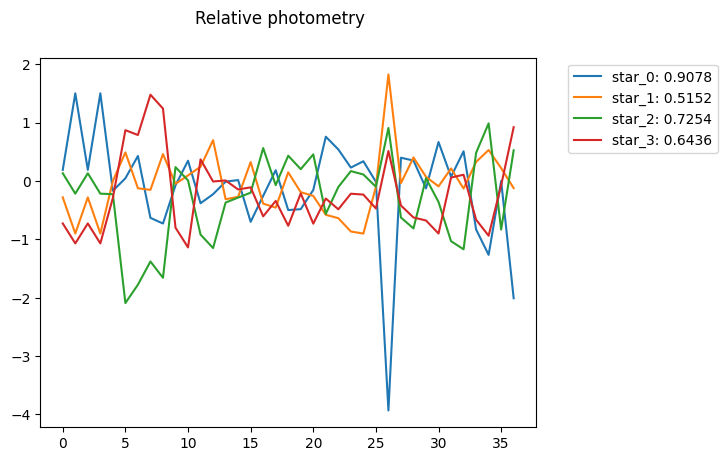

#################  Offset Plots  ####################


IndexError: index 36 is out of bounds for axis 0 with size 36

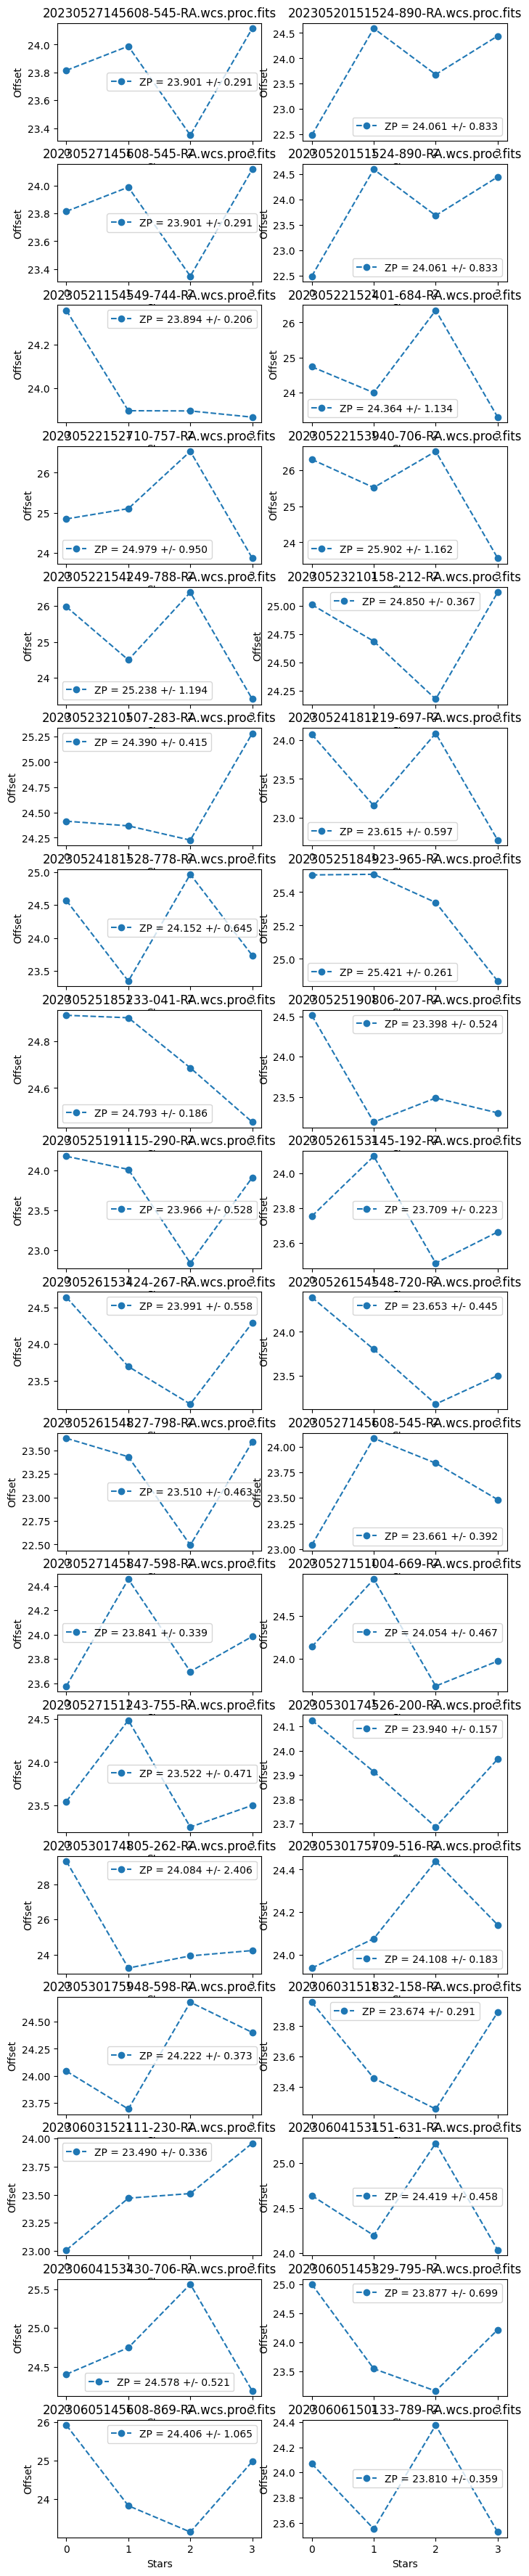

In [62]:
sel_stars = [0, 1, 2, 3, 4, 5]
rej_stars = [4,5]
print("#################  Relative Photometry  ####################")
get_rel_phot(data, sel_stars, rej_stars)
print("#################  Offset Plots  ####################")
zp, ZP_err = get_ZP(data, sel_stars, rej_stars)

In [63]:
def plot_uband_mag(jd, target_mag, target_mag_err, ZP, ZP_err, title='u-band title'):
    cal_mag = target_mag + ZP
    cal_mag_err = (np.sqrt(target_mag_err**2 + ZP_err**2))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(jd, cal_mag, yerr=cal_mag_err,
                fmt='.', label='u-band', color='blue')
    ax.set_xlabel('JD')
    ax.set_ylabel('magnitude(AB)')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.gca().invert_yaxis()
    plt.show()
    return cal_mag, cal_mag_err

In [64]:
cal_mag, cal_mag_err = plot_uband_mag(jd, target_mag, target_mag_err, ZP, ZP_err, title='u-band title')

ValueError: operands could not be broadcast together with shapes (37,) (2,) 

## Taking weighted mean of magnitudes of the same day

In [65]:
# To further reduce the error
tab = pd.DataFrame()
add_data = pd.DataFrame(columns=['Image', 'JD', 'mag', 'mag_err'])
tab['Image'] = image
tab['JD'] = jd
tab['Magnitude'] = cal_mag
tab['e_magnitude'] = cal_mag_err
tab['date'] = tab['Image'].str[:8]
# tab.to_csv('/mnt/disk1/vishwajeet/SN2023ixf/u_band/without_mean_u_band.csv', index=False)

jd_mean_ = []
mag_mean_ = []
e_mag_mean_ = []

for dat in tab['date']:
    condition = tab['date'] == dat
    jd_ = tab[condition]['JD']
    jd_mean = np.average(jd_)
    mag_ = tab[condition]['Magnitude']
    e_mag_ = tab[condition]['e_magnitude']
    pi = 1/e_mag_**2
    p = np.sum(pi)
    mag_mean = np.sum(mag_*pi)/p
    e_mag_mean = 1/np.sqrt(p)
    jd_mean_.append(jd_mean)
    mag_mean_.append(mag_mean)
    e_mag_mean_.append(e_mag_mean)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(jd_mean_, mag_mean_, yerr=e_mag_mean_,
            fmt='.', label='u', color='blue')
ax.set_xlabel('JD')
ax.set_ylabel('magnitude(AB)')
ax.set_title('u-band Lightcurve')
ax.grid(True)
plt.gca().invert_yaxis()
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.legend()
plt.show()

## to save the weighted mean data
u_tab = pd.DataFrame()
add_data = pd.DataFrame(columns=['JD', 'mag', 'e_mag'])
u_tab['JD'] = jd_mean_
u_tab['Filter'] = ['u' for i in range(len(jd_mean_))]
u_tab['Magnitude'] = mag_mean_
u_tab['e_magnitude'] = e_mag_mean_
u_tab.to_csv('/mnt/disk1/vishwajeet/SN2023ixf/u_band/weighted_u_band.csv', index=False)

NameError: name 'cal_mag' is not defined

# Combine all filters data

In [66]:
file_u = '/mnt/disk1/vishwajeet/SN2023ixf/u_band/weighted_u_band.csv'
file_g = '/mnt/disk1/vishwajeet/SN2023ixf/g_band/g_SN2023ixf_Magnitude_table.csv'
file_r = '/mnt/disk1/vishwajeet/SN2023ixf/r_band/r_SN2023ixf_Magnitude_table.csv'
file_i = '/mnt/disk1/vishwajeet/SN2023ixf/i_band/i_SN2023ixf_Magnitude_table.csv'
file_z = '/mnt/disk1/vishwajeet/SN2023ixf/z_band/z_SN2023ixf_Magnitude_table.csv'
filters = ['u', 'g', 'r', 'i', 'z']
file_paths = {
    'u': file_u,
    'g': file_g,
    'r': file_r,
    'i': file_i,
    'z': file_z
}

combined_table = pd.DataFrame()
for filt in filters:
    print("Filter", filt)
    file_data = pd.read_csv(file_paths[filt])
    file_data = file_data.sort_values(by='JD')
    temp_df = pd.DataFrame({
    'JD': file_data['JD'],
    'Filter': [filt for _ in range(len(file_data['JD']))],
    'Magnitude': file_data['Magnitude'],
    'e_magnitude': file_data['e_magnitude']
    })
    combined_table = pd.concat([combined_table, temp_df], ignore_index=True)
    
combined_table.to_csv('/mnt/disk1/vishwajeet/SN2023ixf/combined_table.csv', index=False)

Filter u


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disk1/vishwajeet/SN2023ixf/u_band/weighted_u_band.csv'

In [67]:
file = '/mnt/disk1/vishwajeet/SN2023ixf/combined_table.csv'
frame = pd.read_csv(file)
frame_u = frame[frame['Filter']=='u']
frame_g = frame[frame['Filter']=='g']
frame_r = frame[frame['Filter']=='r']
frame_i = frame[frame['Filter']=='i']
frame_z = frame[frame['Filter'] == 'z']

bands = ['u', 'g', 'r', 'i', 'z']

jd = {
    'u': frame_u['JD'],
    'g': frame_g['JD'],
    'r': frame_r['JD'],
    'i': frame_i['JD'],
    'z': frame_z['JD']
}


mag = {
    'u': frame_u['mag'],
    'g': frame_g['mag'],
    'r': frame_r['mag'],
    'i': frame_i['mag'],
    'z': frame_z['mag']
}

mag_err = {
    'u': frame_u['e_mag'],
    'g': frame_g['e_mag'],
    'r': frame_r['e_mag'],
    'i': frame_i['e_mag'],
    'z': frame_z['e_mag']
}

color_map = {
    'u': 'blue',
    'g': 'green',
    'r': 'red',
    'i': 'orange',
    'z': 'purple'
}

# Plot the lightcurve for each band
fig, ax = plt.subplots(figsize=(8, 5))
for band in bands:
    ax.errorbar(jd[band], mag[band], yerr=mag_err[band],
                fmt='.', label=f'{band}-band', color=color_map[band])
ax.set_xlabel('JD')
ax.set_ylabel('magnitude(AB)')
ax.set_title('Multi-band Lightcurve')
ax.grid(True)
plt.gca().invert_yaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disk1/vishwajeet/SN2023ixf/combined_table.csv'